**Part 0: Introduction and basic data preprocessing**

In this tutorial we look at the boston house prices competition on kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description

The train set consists of approximately 1400 house properties (features) and the corresponding salePrice. The train set consists of approximately 1400 house properties (features) without the corresponding salePrice. There are 79 features, both continuous and categorical. The aim is use the train set to build a model to predict the salePrice given the features. Models are then applied to the test set, and the predicted salePrices are submitted to Kaggle. Kaggle evaluates the submissions by comparing the predicted values with the observed sales price (which are hidden) using the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted values and the logarithm of the observed sales prices.

We will use both linear regression and DNNs to make predictions. In both cases we will create initial rough models, submit our predictions, and give our score. We will then make alterations to the features (feature engineering), explain intuitively why we are making such changes, and generate new scores for comparison.

In this part we will do some basic preprocessing of the data to prepare for the modeling. We will:
    
    Split the features into numerical and categorical.
    Fill in missing feature values.
    Transformation 'year' features into 'age' features.
    Symmetrise the sale prices.
    Normalise the sale prices and numerical features.
    
Note, in the following parts we will not always use all of the above preprocessing steps. Or we will not do them in exactly the same order depending on some additional data transformations we will perform. In particular, the normalise step is a linear transformation of the columns, and so theoretically it will not effect the linear regression models, and we therefore ignore it for these models.

**Step 1: Examining the features values and splitting into numerical and categorical**

We will first use pandas to examine the features in both the train and test set.

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('input/train.csv') # import train dataset
print(train.shape) # shape of train dataset
train.head() # first 5 rows of train dataset

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There are 1460 train rows, each representing the data for a single house. There are 81 train columns which are clearly labelled at the top: The first column is unique Id of each house, the last is the salePrice, and the remaining 79 are the features. The different features are explained in the document data_description.txt.

In [3]:
test = pd.read_csv('input/test.csv') # import test dataset
print(test.shape) # shape of test dataset
test.head() # first 5 rows of test dataset

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


There are 1459 test rows, each representing the data for a single house. There are 80 test columns which are clearly labelled at the top: The first column is unique Id of each house, and the remaining 79 are the features. There is no salePrice as we wish to predict this.

We drop the Id columns, saving test Id to a separate variable for the purposes of submission to kaggle later. We will also temporarily remove train salePrice, saving it to a separate variable which we will use later.

In [4]:
train.drop(['Id'], axis=1, inplace=True) # Remove train Id column
submission = test[['Id']] # Create a dataframe which we will need for submission later, and save test Id to the dataset
test.drop(['Id'], axis=1, inplace=True) # Remove test Id column
train_sale_price = train[['SalePrice']] # Dataframe containing the train SalePrice
train.drop(['SalePrice'], axis=1, inplace=True) # Remove train salePrice column

Next we split into numerical features and categorical features.

In [5]:
numerical_features_columns = list(train.select_dtypes(include=[np.number]).columns) # numerical columns list containing all columns which have numbers
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold'] # We will remove MSSubClass and MoSold from numerical column list. We will remove MSSubClass because, though these are numbers, it is clear from data_description.txt that this is categorical. We will remove MoSold because, though months are given as numbers, I think they are more natural as categorical.
numerical_features_columns = list(set(numerical_features_columns) - set(categorical_features_list_to_remove_from_numerical)) # Remove MSSubClass and MoSold from numerical column list. 
train['MSSubClass'] = train['MSSubClass'].apply(str) # Convert train MSSubClass to strings so that they are now categorical
test['MSSubClass'] = test['MSSubClass'].apply(str) # Convert test MSSubClass to strings so that they are now categorical
train['MoSold'] = train['MoSold'].apply(str) # Convert train MoSold to strings so that they are now categorical
test['MoSold'] = test['MoSold'].apply(str) # Convert test MoSold to strings so that they are now categorical
categorical_features_columns = list(set(train.columns) - set(numerical_features_columns)) # Categorical column list contains all features that are not numerical
print(len(numerical_features_columns)) # Number of numerical features
print(len(categorical_features_columns)) # Number of categorical features

34
45


There are 34 numerical features and 79-34 = 45 categorical features.

**Step 2: Dealing with missing feature values**

Next we investigate the missing numerical values in the train and test dataset. Consider first the missing train numerical data.

In [6]:
train_numerical_features_with_missing_values = [(feature, train[feature].isnull().sum()) for feature in numerical_features_columns if train[feature].isnull().sum() > 0] # List of all train numerical features with missing values, paired with the number of missing values
train_numerical_features_with_missing_values

[('GarageYrBlt', 81), ('MasVnrArea', 8), ('LotFrontage', 259)]

Train LotFrontage has 259 missing values, train GarageYrBlt 81, and train MasVnrArea 8. Next the missing test numerical data.

In [7]:
test_numerical_features_with_missing_values = [(feature, test[feature].isnull().sum()) for feature in numerical_features_columns if test[feature].isnull().sum() > 0] # List of all test numerical features with missing values, paired with the number of missing values
test_numerical_features_with_missing_values

[('GarageArea', 1),
 ('BsmtHalfBath', 2),
 ('BsmtFullBath', 2),
 ('BsmtFinSF1', 1),
 ('GarageYrBlt', 78),
 ('GarageCars', 1),
 ('BsmtFinSF2', 1),
 ('MasVnrArea', 15),
 ('BsmtUnfSF', 1),
 ('TotalBsmtSF', 1),
 ('LotFrontage', 227)]

We need to fill in the missing numerical values. We use the value 0 in almost all cases, with the exception of GarageYrBlt. Why 0? Because we guess the data is only missing when, for example, there is no LotFrontage. This is an assumption and may be false. Different choices, for example the median, may give better results.

What about GarageYrBlt? There are 81 missing values in train, 78 in test. This is trickier, we need to choose a 'natural' year for the missing data. Why might this data be missing? Let us look at the train GarageArea feature to get a clue.

In [8]:
train_garage_year_and_zero_area = train[['GarageYrBlt', 'GarageArea']][train['GarageArea'] == 0] # Dataset containing only train GarageYrBlt and GarageArea when GarageArea == 0
print(train_garage_year_and_zero_area.shape) # Shape of dataset train_garage_year_and_zero_area
print(train_garage_year_and_zero_area['GarageYrBlt'].isnull().sum()) # How many missing GarageYrBlt values in train_garage_year_and_zero_area?

(81, 2)
81


All 81 missing train GarageYrBlt values occur when garageArea == 0, i.e., there is no garage!! Now we understand why these values are missing, but it is still difficult to choose a 'natural' year for the missing values. But we must choose something, so we choose the latest year a house was sold. A different choice may work better.

In [9]:
latest_year_house_sold = train['YrSold'].max() # Max of train YrSold column
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True) # All missing values in train GarageYrBlt replaced with latest_year_house_sold
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True) # All missing values in test GarageYrBlt replaced with latest_year_house_sold
train_numerical_features_with_missing_values.remove(('GarageYrBlt', 81))
test_numerical_features_with_missing_values.remove(('GarageYrBlt', 78))

The remaining missing values are filled in with 0 as discussed above.

In [10]:
train_numerical_features_with_missing_values = [item[0] for item in train_numerical_features_with_missing_values] # List of all train numerical features with missing values, now ignoring the number of missing values
for feature in train_numerical_features_with_missing_values:
    train[feature].fillna(0, inplace = True) # All missing values for this train feature are replaced with 0

test_numerical_features_with_missing_values = [item[0] for item in test_numerical_features_with_missing_values]
for feature in test_numerical_features_with_missing_values:
    test[feature].fillna(0, inplace = True) # All missing values for this test feature are replaced with 0

Next we investigate the missing categorical values in the train and test dataset.

In [11]:
train_categoric_features_with_missing_values = [(feature, train[feature].isnull().sum()) for feature in categorical_features_columns if train[feature].isnull().sum() > 0] # List of all train categoric features with missing values, paired with the number of missing values 
train_categoric_features_with_missing_values

[('BsmtExposure', 38),
 ('MasVnrType', 8),
 ('GarageCond', 81),
 ('BsmtCond', 37),
 ('Electrical', 1),
 ('BsmtFinType1', 37),
 ('BsmtFinType2', 38),
 ('GarageType', 81),
 ('GarageQual', 81),
 ('Alley', 1369),
 ('FireplaceQu', 690),
 ('MiscFeature', 1406),
 ('PoolQC', 1453),
 ('Fence', 1179),
 ('BsmtQual', 37),
 ('GarageFinish', 81)]

In [12]:
test_categoric_features_with_missing_values = [(feature, train[feature].isnull().sum()) for feature in categorical_features_columns if test[feature].isnull().sum() > 0] # List of all test categoric features with missing values, paired with the number of missing values
test_categoric_features_with_missing_values

[('BsmtExposure', 38),
 ('Utilities', 0),
 ('MasVnrType', 8),
 ('MSZoning', 0),
 ('GarageCond', 81),
 ('BsmtCond', 37),
 ('BsmtFinType1', 37),
 ('KitchenQual', 0),
 ('BsmtFinType2', 38),
 ('GarageType', 81),
 ('Functional', 0),
 ('GarageQual', 81),
 ('Alley', 1369),
 ('FireplaceQu', 690),
 ('MiscFeature', 1406),
 ('PoolQC', 1453),
 ('Exterior2nd', 0),
 ('Exterior1st', 0),
 ('Fence', 1179),
 ('SaleType', 0),
 ('BsmtQual', 37),
 ('GarageFinish', 81)]

We need to fill in the missing categorical values. Take, for example, train Alley. data_description.txt describes Alley as the type of alley access to property with possible values:

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
       
Also, as seen above there are 1369 missing train Alley values, and otherwise it has the following value counts.

In [13]:
train['Alley'].value_counts() # Unique value counts for train Alley

Grvl    50
Pave    41
Name: Alley, dtype: int64

It seems reasonable to us that values are missing when there in no alley access, and so we choose to fill in the missing values with 'NA'. Similarly, a look at data_description.txt gives us the following list of categorical features which also have possible value 'NA', and we choose to fill in all missing values for these features with 'NA'.

In [14]:
categoric_features_with_NA = [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature' 
] # All categoric values with possible value NA according to data_description.txt

train_categoric_features_with_missing_values = [item[0] for item in train_categoric_features_with_missing_values] # List of all train categoric features with missing values, ignoring the number of missing values 
test_categoric_features_with_missing_values = [item[0] for item in test_categoric_features_with_missing_values] # List of all test categoric features with missing values, ignoring the number of missing values 

for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA: # For all train categoric features with missing values, that have possible value NA 
        train[feature].fillna('NA', inplace = True) # All missing values for this train feature are replaced with NA
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA: # For all test categoric features with missing values, that have possible value NA
        test[feature].fillna('NA', inplace = True) # All missing values for this test feature are replaced with NA

Now for the remaining categorical features. Consider for example, test MSZoning, which we can see above has 4 missing values. The other values it takes have the following counts.

In [15]:
test['MSZoning'].value_counts() # Unique value counts for test MSZoning

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

We choose to fill in the missing values with 'RL', the most numerous category, which we can obtain as follows.

In [16]:
test['MSZoning'].value_counts().idxmax() # The unique value that occurs most often in test MSZoning

'RL'

We choose to do similarly for the remaining categorical features.

In [17]:
for feature in train_categoric_features_with_missing_values:
    if feature not in categoric_features_with_NA: # For all train categoric features with missing values, that do not have possible value NA 
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True) # All missing values for this train feature are replaced with the most numerous value of that feature
        
for feature in test_categoric_features_with_missing_values:
    if feature not in categoric_features_with_NA: # For all test categoric features with missing values, that do not have possible value NA 
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True) # All missing values for this test feature are replaced with the most numerous value of that feature

**Step 3: Year to age transformations**

Next we transform the 'year' features to 'age' features which seems more relevant to us.

In [18]:
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'] # The old year features
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt'] # The train house age when sold
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd'] # The train remodel age when sold
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt'] # The train garage age when sold
train['AgeOfSale'] = latest_year_house_sold - train['YrSold'] # How long ago the train house was sold, relative the the latest year a house was sold
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt'] # The test house age when sold
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd'] # The test remodel age when sold
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt'] # The test garage age when sold
test['AgeOfSale'] = latest_year_house_sold - test['YrSold'] # How long ago the test house was sold, relative the the latest year a house was sold
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale'] # The new age features
train.drop(year_features, axis=1, inplace=True) # Remove the old year features from train
test.drop(year_features, axis=1, inplace=True) # Remove the old year features from test
numerical_features_columns = list(set(numerical_features_columns) - set(year_features)) # Remove the old year features from the numerical_features_columns list
numerical_features_columns = list(set(numerical_features_columns).union(set(age_features))) # Add the new age features to the numerical_features_columns list

**Step 4: Saleprice skewness transformation**

We now check the distribution of the salePrice column.

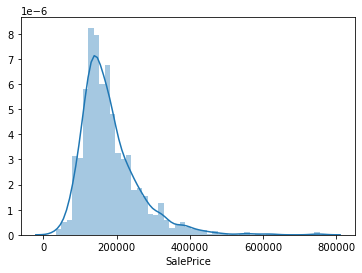

In [19]:
import seaborn as sns
from scipy import stats
sns.distplot(train_sale_price['SalePrice']) # distribution plot of train SalePrice

salePrices are clearly skewed towards smaller values. Let us check the distribution after a log transformation.

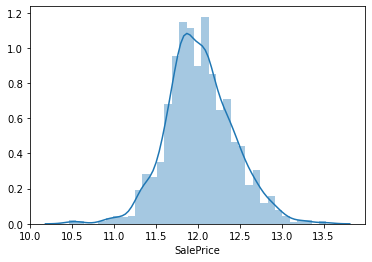

In [20]:
sns.distplot(train_sale_price['SalePrice'].apply(np.log)) # distribution plot of log transformed train SalePrice

This seems more symmetric. We can double check by calculating the skewness.

In [21]:
print(train_sale_price['SalePrice'].skew()) # skewness of train SalePrice
print((train_sale_price['SalePrice']).apply(np.log).skew()) # skewness of log transformed train SalePrice

1.8828757597682129
0.12133506220520406


Without getting into too much detail, asymmetry may be undesirable as it may lead to biases in statistical models, and other reasons. Therefore we now log transform the train SalePrice column. We will predict the log of the sale prices directly (instead of the sale prices themselves). Another reason why this makes sense is because Kaggle evaluates the submissions by calculating the RMSE between the logarithm of the predicted values and the logarithm of the observed sales prices. 

In [22]:
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log) # log transform train salePrice

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


numerical features can also be examined for asymmetry and transformed where appropriate. log transformations cannot be used directly for features which have 0 values (for example, GarageArea is 0 when there is no garage). In that case you might try a box cox transformation. We leave this for now.

**Step 5: Normalise the numerical features and salePrice**

All numerical values in the datasets are non-negative. We now scale/normalise all numerical train columns so that the biggest value in each column is 1. Note, this is a linear transformation of the columns, and so theoretically it will not effect the linear regression models we will soon see. Computationally, there may be some effect because of errors in calculations due to excessively large numbers which may or may not occur depending on the scaling. Normalisation should theoretically have a positive impact when we look at DNNs.

In [23]:
from sklearn.preprocessing import MinMaxScaler # Import a scaler

numerical_train_feature_array = np.array(train[numerical_features_columns]) # A simple array with only the numerical train features
feature_scaler = MinMaxScaler() # Initialise scaler
feature_scaler.fit(numerical_train_feature_array) # Fit scaler to array
train[numerical_features_columns] = pd.DataFrame(feature_scaler.transform(numerical_train_feature_array), columns = numerical_features_columns) # Replace train numerical columns with the scaled values

train_saleprice_array = np.array(train_sale_price) # A simple array with only the train SalePrice
salePrice_scaler = MinMaxScaler() # Initialise scaler
salePrice_scaler.fit(train_saleprice_array) # Fit scaler to array
train_sale_price['SalePrice'] = pd.DataFrame(salePrice_scaler.transform(train_saleprice_array), columns = ['SalePrice']) # Replace SalePrice column with the scaled values

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Let us again check the distribution of the salePrice column to see the effect of the above scaling.

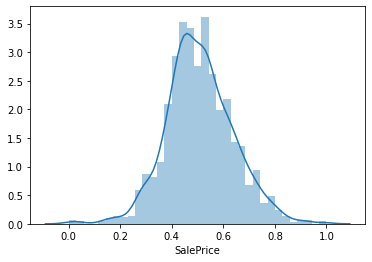

In [26]:
sns.distplot(train_sale_price['SalePrice']) # distribution plot of train SalePrice

The distribution is similar to before (see previous distribution plot above), except now all values are between 0 and 1 as expected.

We finally also scale the numerical test columns using the feature scaler.

In [24]:
numerical_test_feature_array = np.array(test[numerical_features_columns]) # A simple matrix with only the numerical test features
test[numerical_features_columns] = pd.DataFrame(feature_scaler.transform(numerical_test_feature_array), columns = numerical_features_columns) # Replace test numerical columns with the scaled values

We are now done with out basic data preprocessing and can begin modeling.